In [42]:
import os
print(os.getcwd())

/home/data4/jh/data/projects/2020/aggregate/mESC/E14TG2a/cluster/data


In [37]:
import pandas as pd
import numpy as np
from scipy.spatial import distance
import math
from sklearn.cluster import AgglomerativeClustering
import seaborn  as sns
from scipy.cluster.hierarchy import fcluster
import plotly.graph_objects as go
from scipy.stats import mannwhitneyu,kruskal,ttest_ind,f_oneway
#import pickle
#import kaleido
import plotly.io as pio
pio.kaleido.scope.default_format = "pdf"
import plotly.express as px
from matplotlib.colors import ListedColormap
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import fastcluster
from collections import defaultdict
from scipy.stats import mannwhitneyu,kruskal,ttest_ind,f_oneway
import plotly.io as pio
pio.kaleido.scope.default_format = "pdf"
import scikit_posthocs as sp
import itertools
import sys
sys.path.insert(0, '/home/data4/jh/data/tools/customized/tadtools/tadtool_pkg')
import utils as ut
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm

In [2]:
state = pd.read_csv('borders_onlystates.txt',header=None)
#stateM = state.to_numpy().reshape(int(len(state.index)/200),200)
def toIM(s):
    return int(s.strip('E'))
vIM = np.vectorize(toIM)
intstateM=vIM(state)

In [3]:
# def O_O(A,B):
#     upper = sum(A==B) 
#     lower = math.sqrt(len(A)*len(B))
#     return 1-upper/lower
# distM = distance.cdist(state,state,O_O)
# np.save('dist.npy',distM)
distM = np.load('dist.npy')
clustering = AgglomerativeClustering(linkage='complete', n_clusters=2,affinity='precomputed')
y_pred = clustering.fit(distM)

In [6]:
## test seaborn heatmap
flights = sns.load_dataset("flights")
flights = flights.pivot("month", "year", "passengers")
flights

year,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960
month,,,,,,,,,,,,
Jan,112,115,145,171,196,204,242,284,315,340,360,417
Feb,118,126,150,180,196,188,233,277,301,318,342,391
Mar,132,141,178,193,236,235,267,317,356,362,406,419
Apr,129,135,163,181,235,227,269,313,348,348,396,461
May,121,125,172,183,229,234,270,318,355,363,420,472
Jun,135,149,178,218,243,264,315,374,422,435,472,535
Jul,148,170,199,230,264,302,364,413,465,491,548,622
Aug,148,170,199,242,272,293,347,405,467,505,559,606
Sep,136,158,184,209,237,259,312,355,404,404,463,508


Counter({1: 1092, 0: 1045})


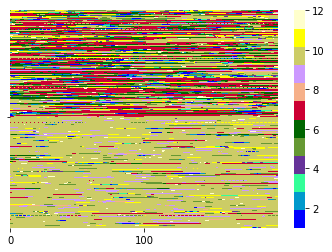

In [10]:
from collections import Counter
print(Counter(y_pred.labels_))
simplet1 = intstateM[y_pred.labels_==0,:]
simplet2 = intstateM[y_pred.labels_==1,:]
# # # simplet3 = distM[y_pred.labels_==2,:]
simplesort = np.concatenate((simplet1,simplet2),axis=0)
stateMplot = sns.heatmap(simplesort,cmap=ListedColormap([(0,0,1),(0,0.6,0.8),(0.2,1,0.6),(0.4,0.2,0.6), (0.4,0.6,0.2),(0,0.4,0),(0.8,0,0.2),(0.96479861, 0.68910113, 0.53756026), (0.8,0.6,1),(0.8,0.8,0.4),(1,1,0),(1,1,0.8)]),xticklabels=100)
stateMplot.set_yticks([1044])
#stateMplot.get_figure().savefig('borders_clsuter.pdf',bbox_inches='tight')
#sns.heatmap(b,cmap='vlag')
# fig = go.Figure(data=go.Heatmap(
#                     z=simplesort,colorscale='Reds'))
# fig.update_layout(template='simple_white',title_text='Agglomerative Cluster',xaxis = dict(showgrid=False,ticks='inside',mirror=True,
#                                                                                    showline=True),
#                 yaxis = dict(showgrid=False, ticks='outside',mirror=True,showline=True,tickmode = 'array',tickvals = [944,944+534],
#                             ticktext = ['P1','P2']),
#                 font=dict(size=18),
#                  title_x=0.5,
#                  showlegend=False)
                  
# fig.write_image('AggloCluster1_2.pdf')

In [7]:
border_state = pd.read_csv('borders_states.bed',sep='\t',header=None)
tad = pd.DataFrame()
tad['chr'] = border_state.iloc[:,0]
tad['start'] = border_state.iloc[:,1]
tad['end'] = border_state.iloc[:,2]
tad['type'] = y_pred.labels_
tad.to_csv('Agglo_borders_type.bed',header=False,sep='\t',quoting=3,index=False)

In [3]:
tad = pd.read_csv('Agglo_borders_type.bed',header=None,sep='\t')
p3_tad = pd.read_csv('Agglo_Cluster3.tsv', sep='\t').loc[:,['chrom','start','end']]
# c1_tad = pd.read_csv('Agglo_Cluster1.bed',sep='\t')
# c2_tad = pd.read_csv('Agglo_Cluster2.bed',sep='\t')

In [38]:
def extract_tad_type(borders_type,tad,agglo_type,chrom):
    borders_chr = borders_type.loc[borders_type.iloc[:,0]==chrom,:]
    tad_chr = tad.loc[tad['chrom']==chrom,:]
    upper_dict = defaultdict(list)
    for index, row in borders_chr.iterrows():
        upper_dict[int(row[3])].append(int(row[2]))
    down_dict = defaultdict(list)
    for index, row in borders_chr.iterrows():
        down_dict[int(row[3])].append(int(row[1]))
    tad_chr['type'] = np.where((np.isin(tad_chr['start'],upper_dict[0]))&(np.isin(tad_chr['end'],down_dict[0])),f'{agglo_type}1{agglo_type}1',np.where((np.isin(tad_chr['start'],upper_dict[0]))&(np.isin(tad_chr['end'],down_dict[1])),f'{agglo_type}1{agglo_type}2',f'{agglo_type}2{agglo_type}2'))
    return tad_chr

In [39]:
result_list = []
for chrom in p3_tad['chrom'].unique():
    result_list.append(extract_tad_type(tad,p3_tad,'SA',chrom))
tad_p3_type = pd.concat(result_list, axis=0, join='outer', ignore_index=True, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True)

/home/data4/jh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [11]:
data = pd.read_csv('TAD_ChIP_strength_fpkm_size_E1_interaction_twoborerexpression_innerfpkm.tsv',sep='\t')
colnames = ['chrom','start','end']
def merge_tad(x,y):
    return pd.merge(x,y,how='inner',on=colnames)
data_type = list(map(merge_tad,itertools.repeat(data,7),[tad_p3_type.loc[tad_p3_type['type']=='SA1SA1',:],tad_p3_type.loc[tad_p3_type['type']=='SA1SA2',:],tad_p3_type.loc[tad_p3_type['type']=='SA2SA2',:]]))
data_type[0] = data_type[0].rename(columns={'strength_x':'strength'})
data_type[0] = data_type[0].rename(columns={'E1_x':'E1'})
data_type[0] = data_type[0].rename(columns={'interaction_x':'interaction'})
data_type[0] = data_type[0].rename(columns={'size_x':'size'})
data_type[0] = data_type[0].rename(columns={'border_fpkm.1_x':'border_fpkm'})
data_type[0] = data_type[0].rename(columns={'inner_fpkm.1_x':'inner_fpkm'})

[[Text(0, 0, 'SA11'), Text(1, 0, 'SA12'), Text(2, 0, 'SA22')]]

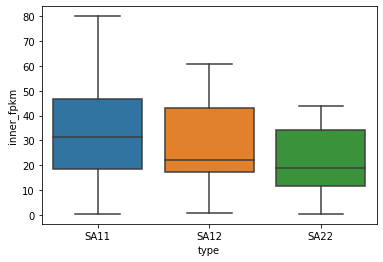

In [12]:
c_fpkm = pd.concat(data_type,ignore_index=True)
c_fpkm['inner_fpkm']=pd.to_numeric(c_fpkm['inner_fpkm'],errors='coerce')

sns.boxplot(x='type',y='inner_fpkm',data=c_fpkm,showfliers=False).set(xticklabels=['SA11','SA12','SA22'])
#plt.savefig('withintadexpression.pdf',bbox_inches='tight',family='sans')

In [9]:
result_list = []
for chrom in c1_tad['chrom'].unique():
    result_list.append(extract_tad_type(tad,c1_tad,'A',chrom))

/home/data4/jh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [10]:
tad_c1_type = pd.concat(result_list, axis=0, join='outer', ignore_index=True, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True)

In [12]:
result_list = []
for chrom in c2_tad['chrom'].unique():
    result_list.append(extract_tad_type(tad,c2_tad,'S',chrom))
tad_c2_type = pd.concat(result_list, axis=0, join='outer', ignore_index=True, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True)

/home/data4/jh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [40]:
# A1A1 = tad_c1_type.loc[tad_c1_type['type']=='A1A1',:]
# A1A2 = tad_c1_type.loc[tad_c1_type['type']=='A1A2',:]
# A2A2 = tad_c1_type.loc[tad_c1_type['type']=='A2A2',:]
# I1I1 = tad_c2_type.loc[tad_c2_type['type']=='S1S1',:]
# I1I2 = tad_c2_type.loc[tad_c2_type['type']=='S1S2',:]
# I2I2 = tad_c2_type.loc[tad_c2_type['type']=='S2S2',:]
SA1SA1 = tad_p3_type.loc[tad_p3_type['type']=='SA1SA1',:]
SA1SA2 = tad_p3_type.loc[tad_p3_type['type']=='SA1SA2',:]
SA2SA2 = tad_p3_type.loc[tad_p3_type['type']=='SA2SA2',:]
# data = pd.read_csv('TAD_ChIP_strength_fpkm_size_E1_interaction_twoborerexpression_innerfpkm.tsv',sep='\t')
# p3_tad = pd.read_csv('Agglo_Cluster3.tsv', sep='\t').loc[:,['chrom','start','end']]
# p3_tad['type'] = ['SA']*len(p3_tad.index)

In [41]:
# A1A1.drop('type',axis=1).to_csv('A1A1.bed',header=False,sep='\t',quoting=3,index=False)
# A1A2.drop('type',axis=1).to_csv('A1A2.bed',header=False,sep='\t',quoting=3,index=False)
# A2A2.drop('type',axis=1).to_csv('A2A2.bed',header=False,sep='\t',quoting=3,index=False)
# I1I1.drop('type',axis=1).to_csv('I1I1.bed',header=False,sep='\t',quoting=3,index=False)
# I1I2.drop('type',axis=1).to_csv('I1I2.bed',header=False,sep='\t',quoting=3,index=False)
# I2I2.drop('type',axis=1).to_csv('I2I2.bed',header=False,sep='\t',quoting=3,index=False)
SA1SA1.drop('type',axis=1).to_csv('SA1SA1.bed',header=False,sep='\t',quoting=3,index=False)
SA1SA2.drop('type',axis=1).to_csv('SA1SA2.bed',header=False,sep='\t',quoting=3,index=False)
SA2SA2.drop('type',axis=1).to_csv('SA2SA2.bed',header=False,sep='\t',quoting=3,index=False)

In [18]:
# A1A1 = pd.read_csv('A1A1.bed',header=None,sep='\t')
# A1A2 = pd.read_csv('A1A2.bed',header=None,sep='\t')
# A2A2 = pd.read_csv('A2A2.bed',header=None,sep='\t')
# I1I1 = pd.read_csv('I1I1.bed',header=None,sep='\t')
# I1I2 = pd.read_csv('I1I2.bed',header=None,sep='\t')
# I2I2 = pd.read_csv('I2I2.bed',header=None,sep='\t')
# colnames = ['chrom','start','end']
# A1A1.columns = colnames
# A1A2.columns = colnames
# A2A2.columns = colnames
# I1I1.columns = colnames
# I1I2.columns = colnames
# I2I2.columns = colnames
A1A1['type'] = itertools.repeat('A11',len(A1A1.index))
A1A2['type'] = itertools.repeat('A12',len(A1A1.index))
A2A2['type'] = itertools.repeat('A22',len(A1A1.index))
I1I1['type'] = itertools.repeat('S11',len(I1I1.index))
I1I2['type'] = itertools.repeat('S12',len(I1I1.index))
I2I2['type'] = itertools.repeat('S22',len(I1I1.index))

In [19]:
sa_list = [tad_p3_type.loc[tad_p3_type['type']=='SA1SA1',:],tad_p3_type.loc[tad_p3_type['type']=='SA1SA2',:],tad_p3_type.loc[tad_p3_type['type']=='SA2SA2',:]]
type_list = sa_list + [A1A1,A1A2,A2A2,I1I1,I1I2,I2I2]
def merge_tad(x,y):
    return pd.merge(x,y,how='inner',on=colnames)
data_type = list(map(merge_tad,itertools.repeat(data,9),type_list))
data_type[0] = data_type[0].rename(columns={'strength_x':'strength'})
data_type[0] = data_type[0].rename(columns={'E1_x':'E1'})
data_type[0] = data_type[0].rename(columns={'interaction_x':'interaction'})
data_type[0] = data_type[0].rename(columns={'size_x':'size'})
data_type[0] = data_type[0].rename(columns={'border_fpkm.1_x':'border_fpkm'})
data_type[0] = data_type[0].rename(columns={'inner_fpkm.1_x':'inner_fpkm'})
#data_type_fpkm = list(map(merge_tad,itertools.repeat(fpkm,7),data_type))

In [22]:
labels = ['SA11','SA12','SA22','A11','A12','A22','S11','S12','S22']

/home/data4/jh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "family" which is no longer supported as of 3.3 and will become an error two minor releases later
  """


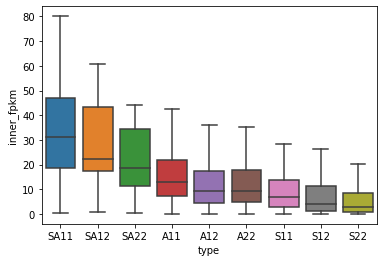

In [21]:
c_fpkm = pd.concat(data_type,ignore_index=True)
c_fpkm['inner_fpkm']=pd.to_numeric(c_fpkm['inner_fpkm'],errors='coerce')

sns.boxplot(x='type',y='inner_fpkm',data=c_fpkm,showfliers=False).set(xticklabels=labels)
plt.savefig('withintadexpression_9.pdf',bbox_inches='tight',family='sans')

/home/data4/jh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "family" which is no longer supported as of 3.3 and will become an error two minor releases later
  


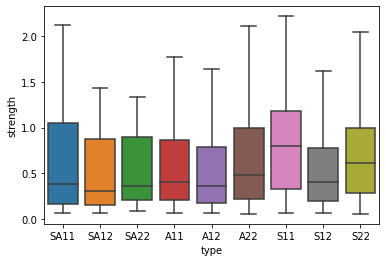

In [23]:
sns.boxplot(x='type',y='strength',data=c_fpkm,showfliers=False).set(xticklabels=labels)
plt.savefig('strength_9.pdf',bbox_inches='tight',family='sans')

/home/data4/jh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "family" which is no longer supported as of 3.3 and will become an error two minor releases later
  


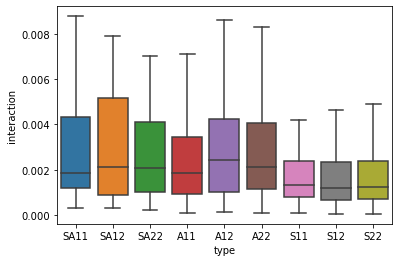

In [24]:
sns.boxplot(x='type',y='interaction',data=c_fpkm,showfliers=False).set(xticklabels=labels)
plt.savefig('interaction_9.pdf',bbox_inches='tight',family='sans')

In [46]:
tad_c1_type.to_csv('C1_type.bed',sep='\t',index=False,quoting=3,header=False)
tad_c2_type.to_csv('C2_type.bed',sep='\t',index=False,quoting=3,header=False)

In [27]:
def plot_p(data,col_name):
    ps_if = ut.sig(data,col_name)
    arr = np.zeros((9,9))
    indices = np.triu_indices(9,1)
    arr[indices] = ps_if   
    ps_if_arr = -np.log10(arr)
    mask = np.zeros_like(ps_if_arr) 
    mask[np.tril_indices_from(mask)] = True
    ps_if_arr
    tab10 = cm.get_cmap('tab10')
    colors = ["white",tab10(3)]
    cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)

    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(7, 5))
        ax = sns.heatmap(ps_if_arr, mask=mask, vmin=0, vmax=5, square=True,cmap=cmap1)
        f.savefig(f'{col_name}_p.pdf',bbox_inches='tight')
    #ax.legend('-log10(p-values)')
# ps_if_arr[ps_if_arr == np.inf] = np.nan
# sns.heatmap(ps_if_arr,cmap='Reds')

/home/data4/jh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


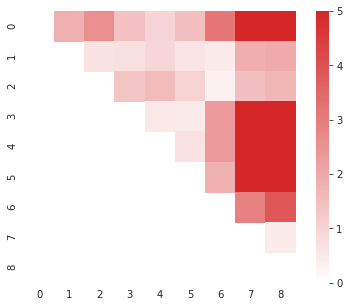

In [28]:
plot_p(data_type,'inner_fpkm')

In [47]:
fpkm_list = list(map(lambda x: x['inner_fpkm'],data_type))
fpkm_pair = list(itertools.combinations(fpkm_list,2))
#print(len(fpkm_pair))
from scipy.stats import mannwhitneyu
for pair in fpkm_pair:
    #print(pair[1])
    stat, p = mannwhitneyu(pair[0], pair[1])
    print(p)

0.3598741342451548
0.428255995577658
0.269308546666114
0.009472439683309934
2.055983180320239e-09
6.050945178555099e-12
0.2919252798610998
0.3122098186487274
0.004578921912129408
1.4827493702400182e-13
2.5582663984242015e-23
0.21513458140367442
0.00489325717377123
6.04995225436293e-11
1.7554192324972407e-15
0.015580578715192358
3.6430844610258927e-11
2.213403818038537e-18
0.0011352675570688098
0.000133254990100269
0.338025453244719


In [48]:
Counter(y_pred.labels_)

Counter({1: 1092, 0: 1045})

In [56]:
type1_borders = tad.loc[tad['type']==0,[True,True,True,False]]
type2_borders = tad.loc[tad['type']==1,[True,True,True,False]]
type1_borders.to_csv('type1_borders.bed',header=False,sep='\t',quoting=3,index=False)
type2_borders.to_csv('type2_borders.bed',header=False,sep='\t',quoting=3,index=False)

,chr,start,end,type
0,chr1,4440000,4480000,1
1,chr1,4800000,4840000,0
2,chr1,6200000,6240000,1
3,chr1,9520000,9560000,1
4,chr1,10160000,10200000,1
...,...,...,...,...
2132,chrX,164480000,164520000,1
2133,chrX,166160000,166200000,1
2134,chrX,167280000,167320000,1
2135,chrX,168640000,168680000,1


In [58]:
tad[tad['type']==0,['chrom','start','end']]

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'